In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
%matplotlib inline

In [2]:
# Graph plotting function; only needed for visualisation
def plot_graph(G, ranks):
    graph = nx.from_numpy_matrix(G.T, create_using=nx.MultiDiGraph)
    fig = plt.figure(figsize=(10, 5))

    layout = nx.circular_layout(graph)
    node_opts = {"node_size": 2000, "node_color": "w", "edgecolors": "k", "linewidths": 2.0}
    edge_opts = {"connectionstyle": 'arc3,rad=0.1', "arrowsize": 20, }
    nx.draw(graph, pos=layout, with_labels=False, **node_opts, **edge_opts)
    node_names = [f"{n}" for n in graph.nodes()] # Numbers for names
    # node_names = [chr(65+(n % 25))+(chr(65+(n//25)) if n//25 else '') for n in graph.nodes()]  # Letters for names
    labels = {
        n: f"$\mathbf{{{node_names[n]}}} $\n{ranks[n]:.3f}" for n in graph.nodes()}
    nx.draw_networkx_labels(G, pos=layout, labels=labels)

# Problem 2: PageRank algorithm (3 pts out of 12)

### <div align="right"> &copy; Ostap Dyhdalovych & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   First team member
*   Second team member


---
## Introduction

#### The core idea of the PageRank algorithm is determining the popularity of each page on the Internet, i.e., the percentage of users reading the page at any given moment. Let us model the Internet surfing process of a randomly sampled user, who starts at a random page and at each step follows a random link to another site (chosen with equal probabilities from all available ones)

#### Then the probability that a user visits the website $u$ at a step $k$ is calculated as $r_{u, k} = \sum_{i\rightarrow u}\frac{r_{i, k-1}}{l_i}$ where $l_i$ is the number of outgoing links from the page $i$. Or, in  matrix form, $\mathbf{r}_k = L\mathbf{r}_{k-1}$, where $L$ is an adjacency matrix of the graph, with each column divided by it's sum; $L_{i, j}$ represents probability of going from the page $i$ to page $j$. We want to determine the equilibrium percentages, where $L\mathbf{r} = \mathbf{r}$

#### The equation above can be solved directly, but this is unfeasible for  large matrices. Instead, we can interpret $L$ as a Markov matrix; if it is regular, then subsequent iterations $\mathbf{r}_k = L\mathbf{r}_{k-1}$ will converge to the true solution $\mathbf{r}$

#### Note: you will be using the $\mathtt{networkx}$ library for graph representations and manipulations
---



## **1. Basic PageRank (0.5 pts)**
#### Implement the basic PageRank algorithm below and test it on a simple graph. Do the results look intuitive? Test different initial rank distributions and iteration counts

In [3]:
def PageRank_1(G, num_steps=10, ranks=None):
    """
    Obtain transition probability matrix L from G. At each step, use L to calculate r(k) from r(k-1).

    Args:
        G: graph adjacency matrix; `np.array(n, n)`
        num_steps: number of iteratons, `int`
        ranks: initial page ranks; `np.array(n,)` or `None`
    Returns:
        r: ranks of each node in G; `np.array(n, )`
    """
    if ranks is None:
        ranks = np.ones(G.shape[0])/G.shape[0]
    assert G.shape[0] == G.shape[1]
    assert ranks.shape[0] == G.shape[0]
    # ====================
    L = G / np.sum(G, axis=0, keepdims=True)

    for _ in range(num_steps):
        ranks = np.dot(L, ranks)
    # ====================
    return ranks

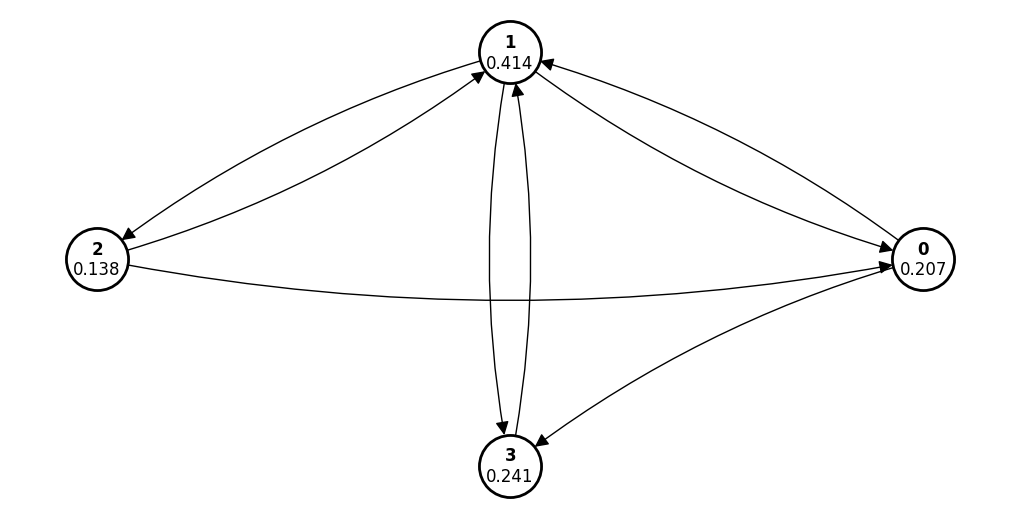

In [4]:
G = np.array([[0, 1, 1, 0],
              [1, 0, 1, 1],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)

# ====================
ranks_ = PageRank_1(G, num_steps=100, ranks=ranks)
plot_graph(G, ranks_)

---

The resulting ranks represent the user's probabilities of finding itself on the corresponding pages after `num_steps` number of steps. The result that is obtained looks quite intuitive, as node \#1 has the most number of incoming links as well as the highest rank, and node \#2 has the least number of incoming links and the lowest rank. 

Note that ranks are defined not only by the number of incoming links, but also by the ranks of nodes that these links come from.

---

## **2. Fixing "dead end" nodes (0.8 pt)**

### **2.1 (0.4 pts)** How does the above algorithm work if there are nodes without outgoing links ("dead" nodes)?  


/var/folders/18/7hp8jt894852l88s14_4jzy00000gn/T/ipykernel_69203/306868194.py:17: RuntimeWarning: invalid value encountered in divide
  L = G / np.sum(G, axis=0, keepdims=True)


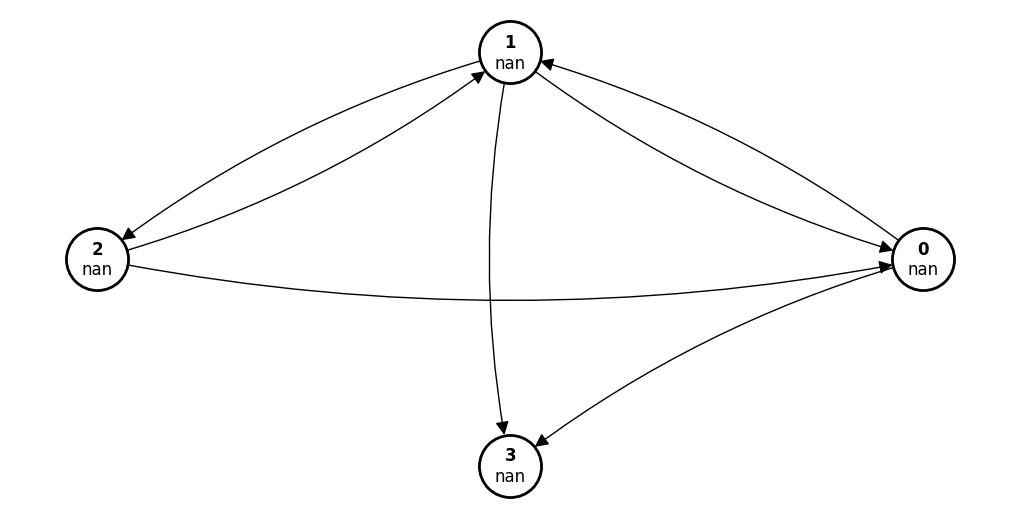

In [5]:
G = np.array([[0, 1, 1, 0],
              [1, 0, 1, 0],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)

# ====================
ranks_ = PageRank_1(G, num_steps=10, ranks=ranks)
plot_graph(G, ranks_)

---

When some node has no outgoing links, the probability of the user going to some other page from this node is hard to define because rationally this probability equals zero, but on the other hand, the sum of probabilities to go to other pages is also zero and not one. 

From a computational point of view, we get uncertainty when trying to construct an adjacency matrix because of division by zero-sum.

---

### **2.2 (0.4 pts)**
#### The simplest solution in the case with "dead end" nodes is to add random jumps from them to any other node: $$L' = L + \mathbf{1}\mathbf{d}^\top/n,$$ where $\mathbf{1}$ is a vector of 1s, and $\mathbf{d}$ is a vector with ones at dead nodes and zeros otherwise.
#### Modify the basic algorithm and test it on the graph below


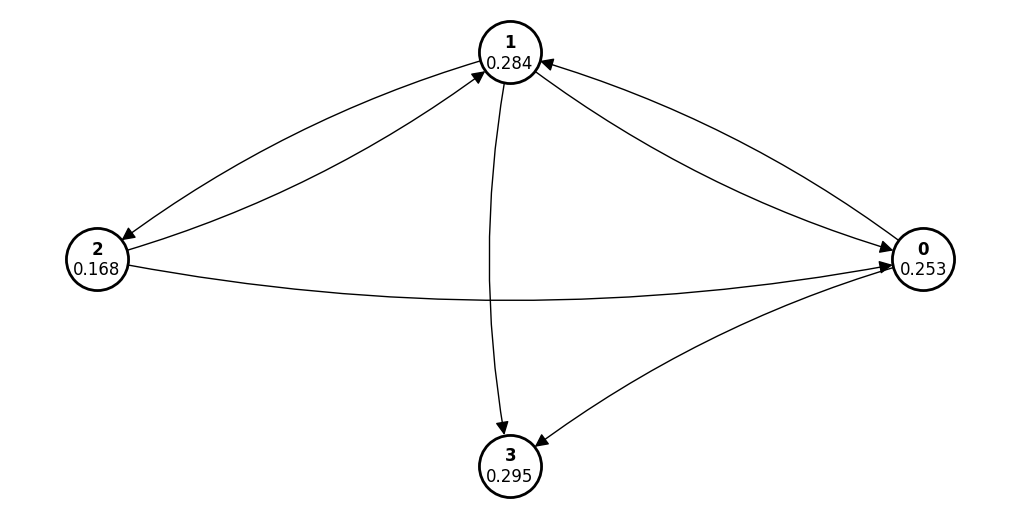

In [6]:
def PageRank_2(G, num_steps=10, ranks=None):
    """
    Add random jumps from dead nodes

    Args:
        G: graph adjacency matrix; `np.array(n, n)`
        num_steps: number of iteratons, `int`
        ranks: initial page ranks; `np.array(n,)` or `None`
    Returns:
        r: ranks of each node in G; `np.array(n, )`
    """
    if ranks is None:
        ranks = np.ones(G.shape[0])/G.shape[0]
    assert G.shape[0] == G.shape[1]
    assert ranks.shape[0] == G.shape[0]
    # ====================
    P = G/(G.sum(axis=0) + 1e-20) + np.outer(np.ones(G.shape[0]), G.sum(axis=0)==0)/G.shape[0]
    
    for _ in range(num_steps):
        ranks = P.dot(ranks)
    # ====================
    return ranks

G = np.array([[0, 1, 1, 0],
              [1, 0, 1, 0],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)

# ====================
ranks_ = PageRank_2(G, num_steps=10, ranks=ranks)
plot_graph(G, ranks_)

---

We remedy an issue with zero division by introducing equal probability to go to any page from a page with no outgoing links. 

This can be reasonably explained, as on a page with no outgoing links, the only option is to start a new search. 

---

## **3. Making the Markov chain regular (1.2 pts)**

### **3.1 (0.4 pts)**
#### Test the same algorithm on two slightly more specific graphs; try different initial rank distributions. Do the results still seem intuitive? What can be the problem?

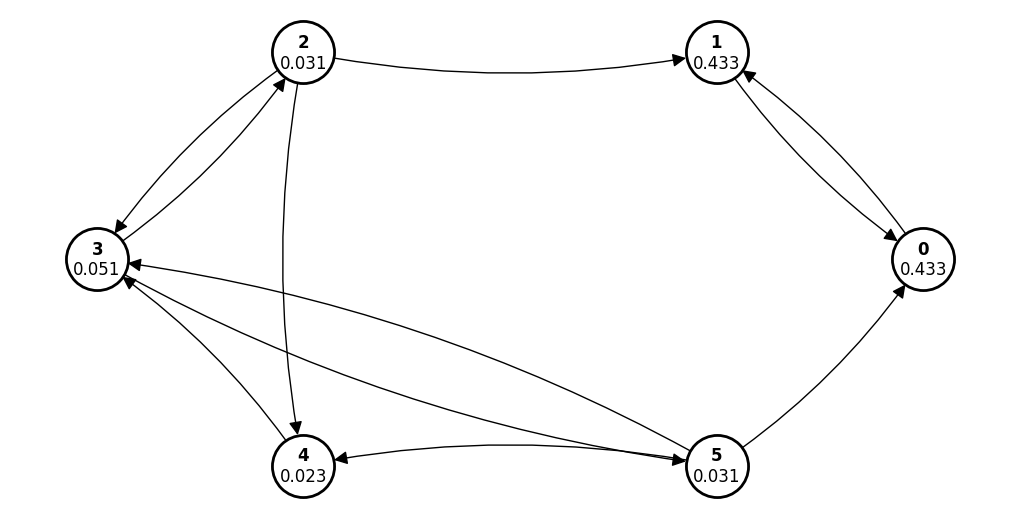

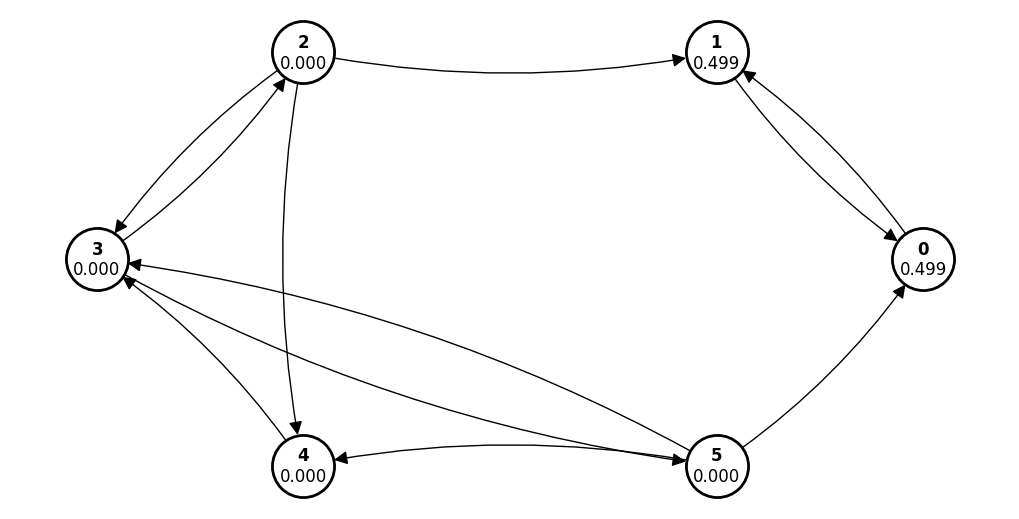

In [7]:
G = np.array([[0, 1, 0, 0, 0, 1],
              [1, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0]])

ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)
# ====================

ranks_ = PageRank_2(G, num_steps=10, ranks=ranks)
plot_graph(G, ranks_)
ranks_ = PageRank_2(G, num_steps=40, ranks=ranks)
plot_graph(G, ranks_)

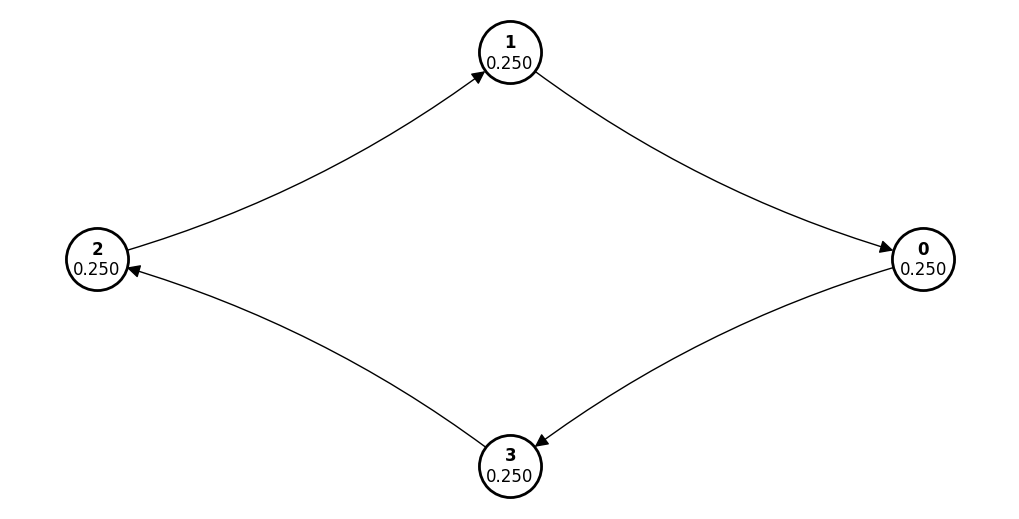

In [8]:
G = np.array([[0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1, 0, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)
# ====================

ranks_ = PageRank_2(G, num_steps=10, ranks=ranks)
plot_graph(G, ranks_)


---

In the first scenario, there are two nodes that point only to each other, forming a loop with no outgoing connections, so after some step at which the user enters one of those pages, his only possibility is to find himself on one of them. This way, the ranks of these two nodes will converge to 0.5, and any other will decrease to zero.

In the second scenario, we observe a similar situation, but now there is only a loop of length four, so the probability to end up on any page assuming that the starting page is arbitrary is equal to $\frac{1}{<\text{length of loop}>}=0.25$.

---



### **3.2 (0.4 pts)**
#### To remedy the above problems, a small probability of a random jump is added to every node (fresh start):  $$Q = (1 - \alpha) L' + \alpha\mathbf{1}\mathbf{1}^\top.$$ Show that this makes the matrix regular


---



---

### **3.3 (0.4 pts)**
#### Implement this modification and test it on the same graphs. How does the choice of $\alpha$ influence the resulting ranks?

In [9]:
def PageRank_3(G, num_steps=10, ranks=None, alpha = 0.15):
    """
    Add random jumps from every node with probability `alpha`
    Args:
        G: graph adjacency matrix; `np.array(n, n)`
        num_steps: number of iteratons, `int`
        alpha: random jump probability, `float`
        ranks: initial page ranks; `np.array(n,)` or `None`
    Returns:
        r: ranks of each node in G; `np.array(n, )`
    """
    if ranks is None:
        ranks = np.ones(G.shape[0])/G.shape[0]
    assert G.shape[0] == G.shape[1]
    assert ranks.shape[0] == G.shape[0]
    # ====================
    P = G/(G.sum(axis=0) + 1e-20) + np.outer(np.ones(G.shape[0]), G.sum(axis=0)==0)/G.shape[0]
    Q = (1-alpha)*P + alpha*np.ones(P.shape)
    for _ in range(num_steps):
        ranks = Q.dot(ranks)
    # ====================
    return ranks

Text(0.5, 1.0, 'num_steps = 40; alpha = 1 (normalized ranks)')

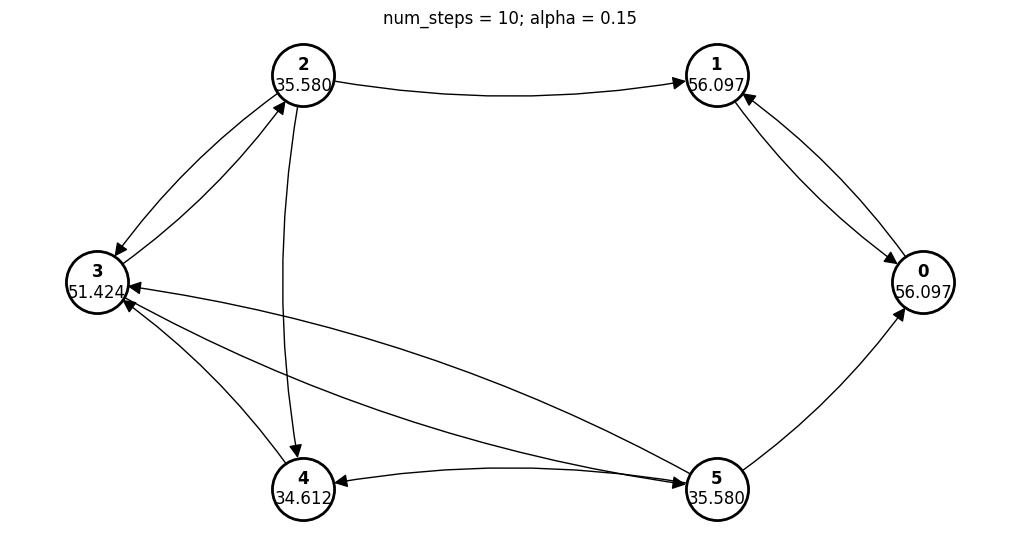

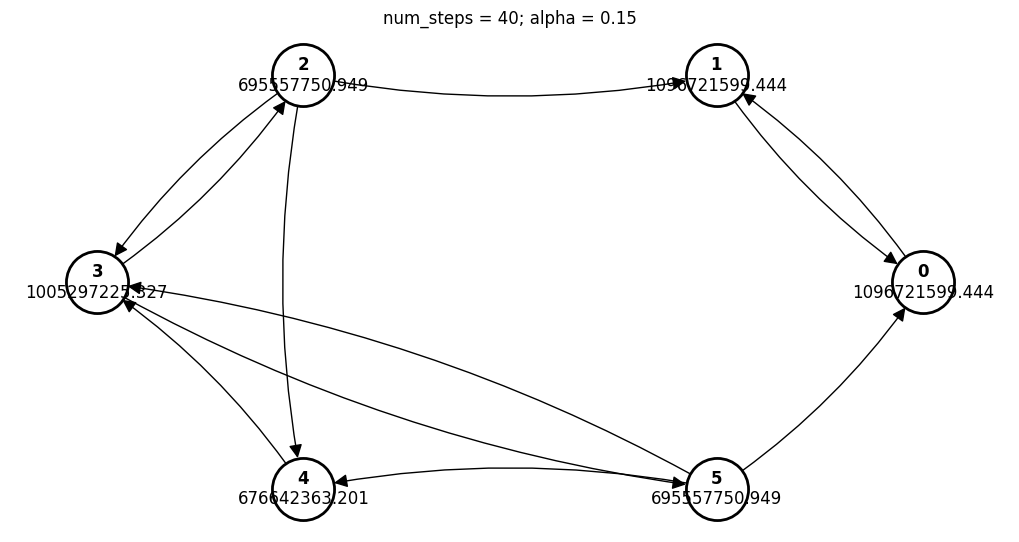

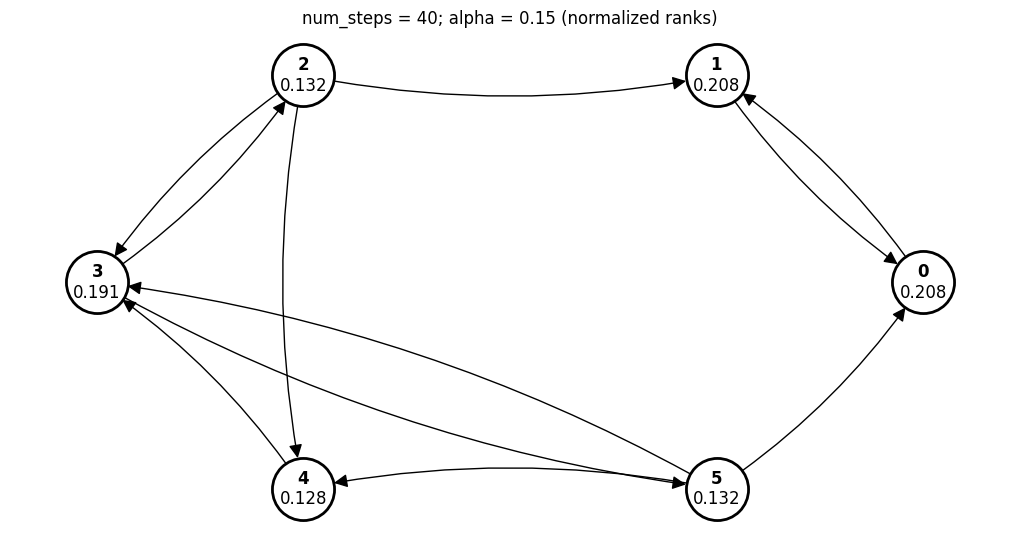

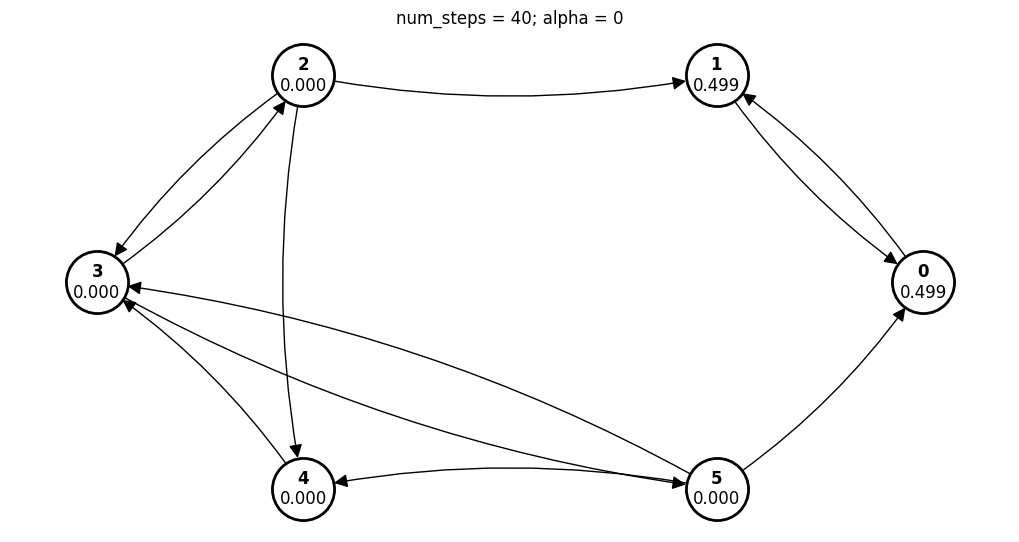

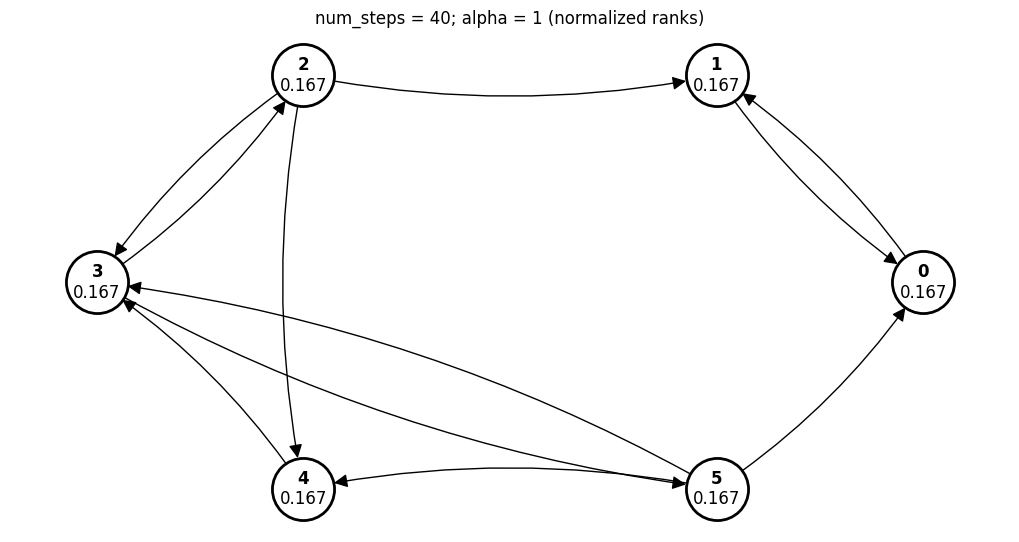

In [10]:
G = np.array([[0, 1, 0, 0, 0, 1],
              [1, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],])

ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)

# ====================
ranks_ = PageRank_3(G, num_steps=10, ranks=None, alpha = 0.15)
plot_graph(G, ranks_)
plt.title("num_steps = 10; alpha = 0.15")

ranks_ = PageRank_3(G, num_steps=40, ranks=None, alpha = 0.15)
plot_graph(G, ranks_)
plt.title("num_steps = 40; alpha = 0.15")

plot_graph(G, ranks_/sum(ranks_))
plt.title("num_steps = 40; alpha = 0.15 (normalized ranks)")

ranks_ = PageRank_3(G, num_steps=40, ranks=None, alpha = 0)
plot_graph(G, ranks_)
plt.title("num_steps = 40; alpha = 0")

ranks_ = PageRank_3(G, num_steps=40, ranks=None, alpha = 1)
plot_graph(G, ranks_/sum(ranks_))
plt.title("num_steps = 40; alpha = 1 (normalized ranks)")

Text(0.5, 1.0, 'num_steps = 10; alpha = 1 (normalized ranks)')

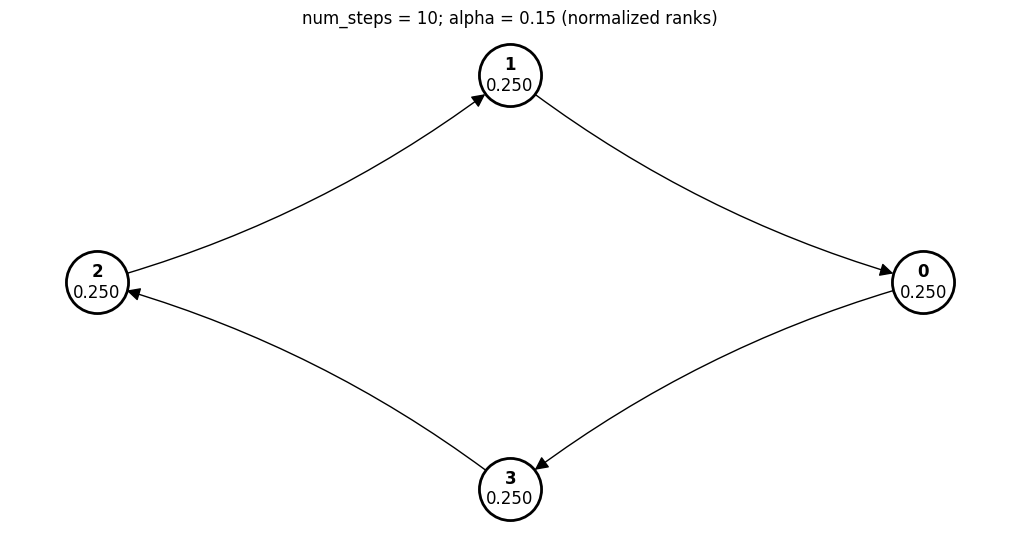

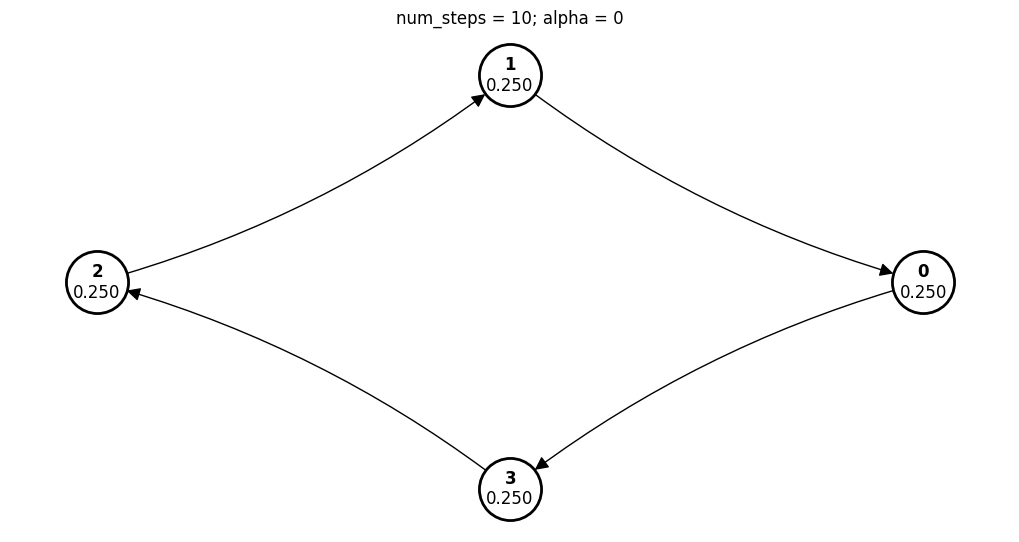

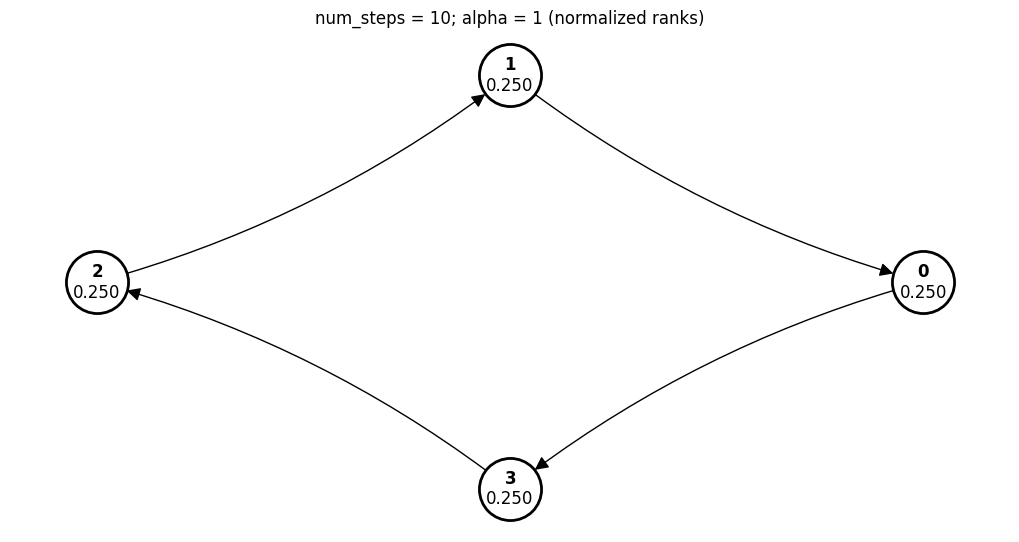

In [11]:
G = np.array([[0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1, 0, 0, 0]])
ranks = np.ones(G.shape[0])/G.shape[0]
# plot_graph(G, ranks)

# ====================
ranks_ = PageRank_3(G, num_steps=10, ranks=None, alpha = 0.15)
plot_graph(G, ranks_/sum(ranks_))
plt.title("num_steps = 10; alpha = 0.15 (normalized ranks)")

ranks_ = PageRank_3(G, num_steps=10, ranks=None, alpha = 0)
plot_graph(G, ranks_)
plt.title("num_steps = 10; alpha = 0")

ranks_ = PageRank_3(G, num_steps=10, ranks=None, alpha = 1)
plot_graph(G, ranks_/sum(ranks_))
plt.title("num_steps = 10; alpha = 1 (normalized ranks)")

---

After introducing random jumps, the distribution of ranks became more even. 

In the first scenario, it allowed us to decrease the dominance of the loop, and in the second scenario, it did not change much, which is expected.

We plotted normalized ranks for the convenience of making observations.

---





## **4. PageRank on moderate-sized graphs (0.5 pt)**
<!-- Which metrics can be used to analyze performance on large graphs? -->
#### Randomly generate adjacency matrix for a moderate-sized graph (~100 nodes); remember to remove the diagonal entries. Test how different choices of $\alpha$ and different iteration counts affect the results. Summarize your findings below

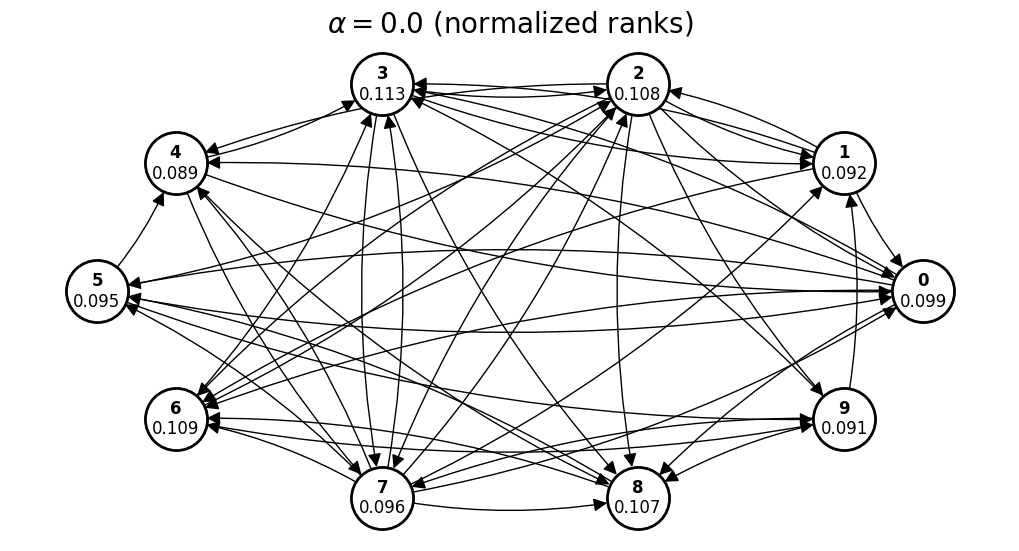

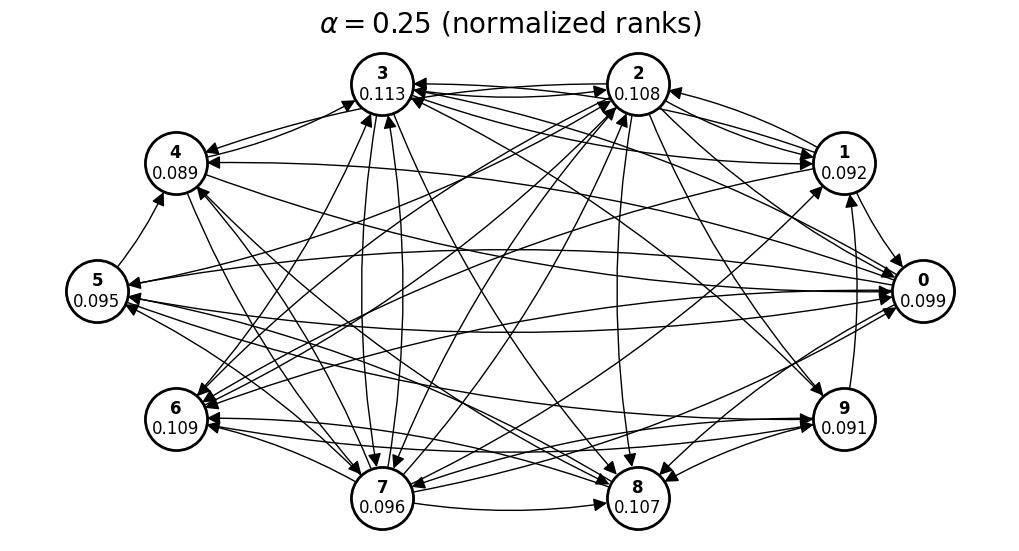

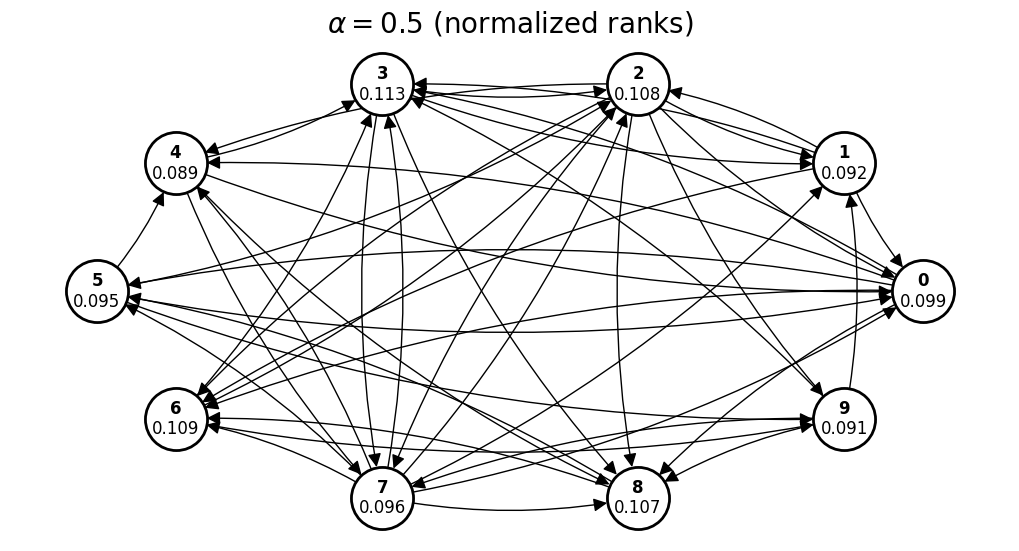

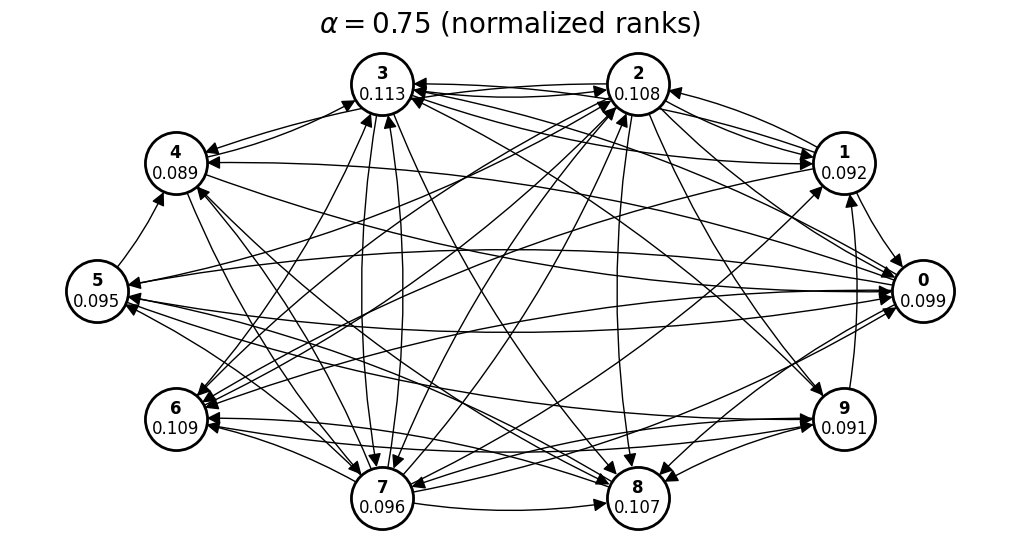

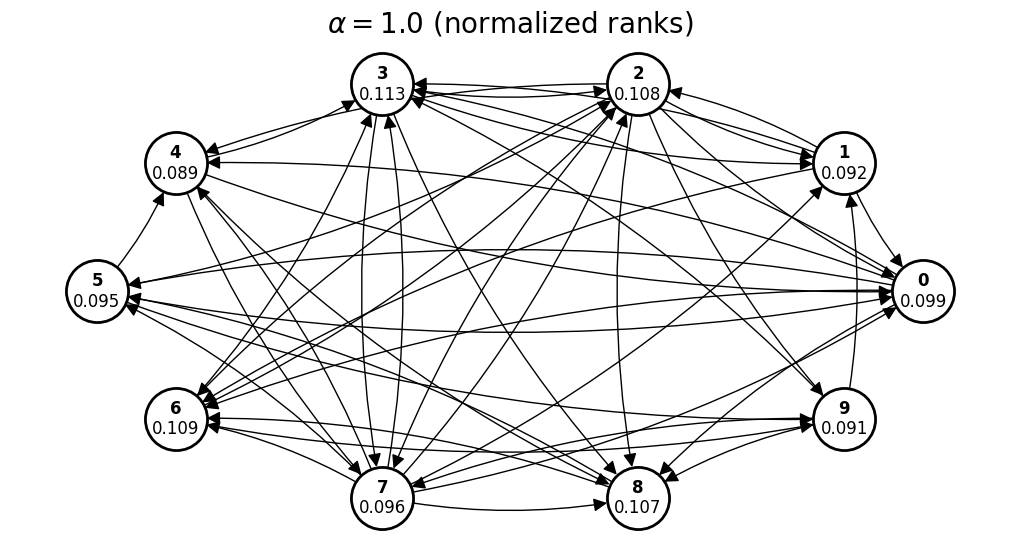

In [12]:
# ====================
n = 10
G = np.random.randint(2, size=(n, n))
np.fill_diagonal(G, 0)

for alpha in np.linspace(0, 1, 5):
    ranks_ = PageRank_3(G, num_steps=10, ranks=None, alpha = 0.15)
    plot_graph(G, ranks_/sum(ranks_))
    plt.title(fr"$\alpha = {alpha}$ (normalized ranks)", fontsize=20)

---

When $\alpha$ equals 0, it gives us the same result as before, indicating there is no randomness, and when alpha equals 1, the ranks are equal, meaning the pages are visited completely at random.

Here, we conclude that it is beneficial to have some reasonable $\alpha$ that would represent random user decition to start a new search.

---